In [ ]:
!pip install opencv-python-headless numpy torch ultralytics scikit-learn tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
import cv2
import numpy as np
import torch
from ultralytics import YOLO
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import Video, display
import glob

# Preprocessing: Background Subtraction and Image Normalization
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    fgbg = cv2.createBackgroundSubtractorMOG2()
    fgmask = fgbg.apply(gray)
    masked_img = cv2.bitwise_and(frame, frame, mask=fgmask)
    normalized_img = masked_img / 255.0
    return normalized_img, frame

# Object Detection with YOLOv8
def detect_animals(frame, model_path='yolov8n.pt'):
    model = YOLO(model_path)
    results = model(frame)
    boxes = results[0].boxes.xyxy.cpu().numpy()  # [x1, y1, x2, y2]
    return boxes

# CNN Classifier for Species Identification
def build_cnn_classifier(num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Movement Clustering with KMeans
def cluster_movement_patterns(features, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)
    return labels

# Core Processing Function for a Single Frame
def process_frame(frame, cnn_model, species_names=None):
    processed_img, original_frame = preprocess_frame(frame)
    boxes = detect_animals(original_frame)
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(cv2.cvtColor(original_frame, cv2.COLOR_BGR2GRAY), None)
    if descriptors is None:
        descriptors = np.zeros((1, 32))  # Fallback for no features
    cluster_labels = cluster_movement_patterns(descriptors)
    species_predictions = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        roi = original_frame[y1:y2, x1:x2]
        if roi.size == 0:
            continue
        roi_resized = cv2.resize(roi, (224, 224))
        roi_normalized = roi_resized / 255.0
        pred = cnn_model.predict(np.expand_dims(roi_normalized, axis=0), verbose=0)
        species_id = np.argmax(pred, axis=1)[0]
        species_name = species_names[species_id] if species_names else str(species_id)
        species_predictions.append(species_name)
    return boxes, species_predictions, cluster_labels, original_frame

# Process a Single Image
def process_image(image_path, cnn_model, species_names=None):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    boxes, species, clusters, annotated_frame = process_frame(img, cnn_model, species_names)
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(annotated_frame, species[i], (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    output_path = "output_" + os.path.basename(image_path)
    cv2.imwrite(output_path, annotated_frame)
    return boxes, species, clusters, output_path

# Process a Video
def process_video(video_path, cnn_model, species_names=None, output_video_path="output_video.mp4"):
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video not found: {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Failed to open video: {video_path}")
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    results = []
    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            boxes, species, clusters, annotated_frame = process_frame(frame, cnn_model, species_names)
            for i, box in enumerate(boxes):
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(annotated_frame, species[i], (x1, y1-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            out.write(annotated_frame)
            results.append((boxes, species, clusters))
    finally:
        cap.release()
        out.release()
        cv2.destroyAllWindows()
    return results, output_video_path

# Main function for Colab
def main():
    # Initialize CNN classifier
    cnn_model = build_cnn_classifier(num_classes=10)

    # Example species names
    species_names = [
        "Elephant", "Lion", "Cheetah", "Rhino", "Zebra",
        "Giraffe", "Leopard", "Buffalo", "Tiger", "Hyena"
    ]

    # Prompt user for input type
    print("Choose input type: 'image' or 'video'")
    input_type = input().strip().lower()
    while input_type not in ['image', 'video']:
        print("Invalid input. Please enter 'image' or 'video':")
        input_type = input().strip().lower()

    # Upload file
    print(f"Please upload your {input_type} file:")
    uploaded = files.upload()
    if not uploaded:
        raise ValueError(f"No {input_type} file uploaded")

    # Get the uploaded file path
    file_path = list(uploaded.keys())[0]

    # Process based on input type
    if input_type == 'image':
        try:
            boxes, species, clusters, output_path = process_image(file_path, cnn_model, species_names)
            print(f"Image processed. Detected {len(boxes)} animals")
            print(f"Species predictions: {species}")
            print(f"Movement clusters: {clusters}")
            print(f"Annotated image saved to: {output_path}")
            # Display the output image
            img = cv2.imread(output_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(10, 10))
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.show()
            # Provide download link
            files.download(output_path)
        except Exception as e:
            print(f"Error processing image: {e}")

    elif input_type == 'video':
        try:
            results, output_path = process_video(file_path, cnn_model, species_names)
            print(f"Video processed. Results for {len(results)} frames saved to: {output_path}")
            for i, (boxes, species, clusters) in enumerate(results):
                print(f"Frame {i+1}: Detected {len(boxes)} animals, Species: {species}, Clusters: {clusters}")
            # Display the output video
            display(Video(output_path, embed=True))
            # Provide download link
            files.download(output_path)
        except Exception as e:
            print(f"Error processing video: {e}")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Choose input type: 'image' or 'video'
Please upload your video file:


Saving 2342260-hd_1920_1080_30fps.mp4 to 2342260-hd_1920_1080_30fps.mp4

0: 384x640 (no detections), 199.3ms
Speed: 6.9ms preprocess, 199.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 150.2ms
Speed: 4.4ms preprocess, 150.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 223.6ms
Speed: 3.9ms preprocess, 223.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 240.6ms
Speed: 5.6ms preprocess, 240.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 233.1ms
Speed: 4.6ms preprocess, 233.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 231.3ms
Speed: 4.3ms preprocess, 231.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 161.7ms
Speed: 6.0ms preprocess, 161.7ms inference, 0.9ms postprocess per image at shape 

In [ ]:
from google.colab import files
print("Upload dataset.zip (folder with subfolders for each species)")
uploaded = files.upload()

Upload dataset.zip (folder with subfolders for each species)


Saving Dataset.zip to Dataset.zip


In [ ]:
!unzip -q Dataset.zip -d /content/

In [ ]:
import os
dataset_path = '/content/Dataset'
print("Classes found:", os.listdir(dataset_path))

Classes found: ['Cheeta', 'Zebra', 'Elephant', 'Lion']


Found 52 images belonging to 4 classes.
Found 11 images belonging to 4 classes.
Class indices: {'Cheeta': 0, 'Elephant': 1, 'Lion': 2, 'Zebra': 3}
Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.1463 - loss: 3.0002 - val_accuracy: 0.3636 - val_loss: 1.4940
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.3106 - loss: 1.4807 - val_accuracy: 0.3636 - val_loss: 1.3017
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2319 - loss: 1.3776 - val_accuracy: 0.3636 - val_loss: 1.3337
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4526 - loss: 1.2990 - val_accuracy: 0.3636 - val_loss: 1.1867
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4526 - loss: 1.2088 - val_accuracy: 0.3636 - val_loss: 1.3275
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4224 - loss: 1.2741 - val_accuracy: 0.2727 - val_loss: 1.3883
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4743 - loss: 1.2010 - val_accuracy: 0.6364 - val_los

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

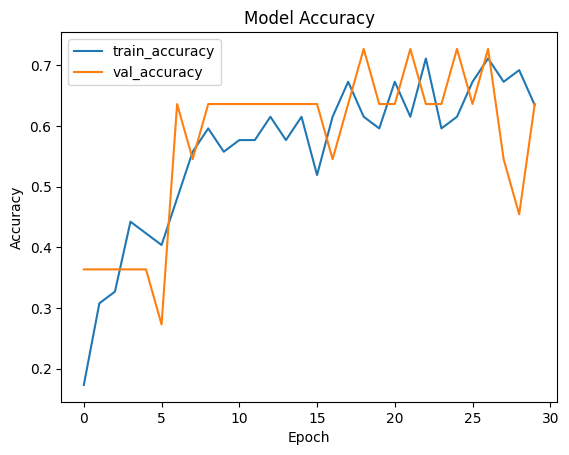

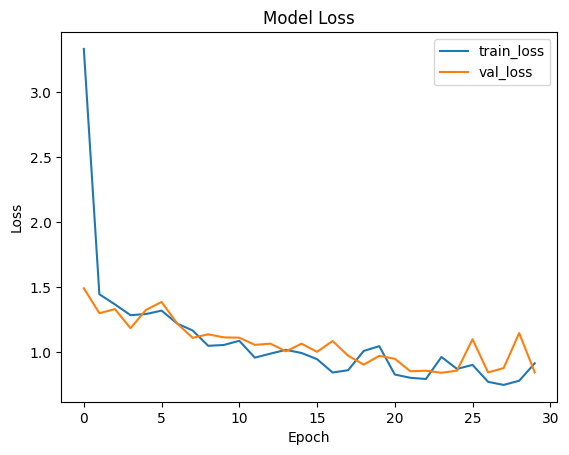

In [14]:
# Install required packages

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from google.colab import files
import os

# Define the CNN classifier
def build_cnn_classifier(num_classes=4):  # Changed to 4 classes
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Added dropout to prevent overfitting
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Set dataset path
dataset_path = '/content/Dataset'

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,        # Increased for small dataset
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,      # Added for more variability
    brightness_range=[0.8, 1.2],  # Adjust brightness
    validation_split=0.2
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=16,  # Smaller batch size for small dataset
    class_mode='categorical',
    subset='training'
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

# Verify class mapping
print("Class indices:", train_generator.class_indices)

# Build and train the model
cnn_model = build_cnn_classifier(num_classes=4)
history = cnn_model.fit(
    train_generator,
    epochs=30,  # Increased epochs for small dataset
    validation_data=validation_generator,
    verbose=1
)

# Save the trained model
cnn_model.save('/content/cnn_model.h5')
files.download('/content/cnn_model.h5')

# Plot training history
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Choose input type: 'image' or 'video'
image

0: 640x640 1 dog, 1 cow, 360.5ms
Speed: 6.8ms preprocess, 360.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Image processed. Detected 2 animals
Species predictions: ['Elephant', 'Elephant']
Movement clusters: [0 0]
Annotated image saved to: output_lioness.jpg


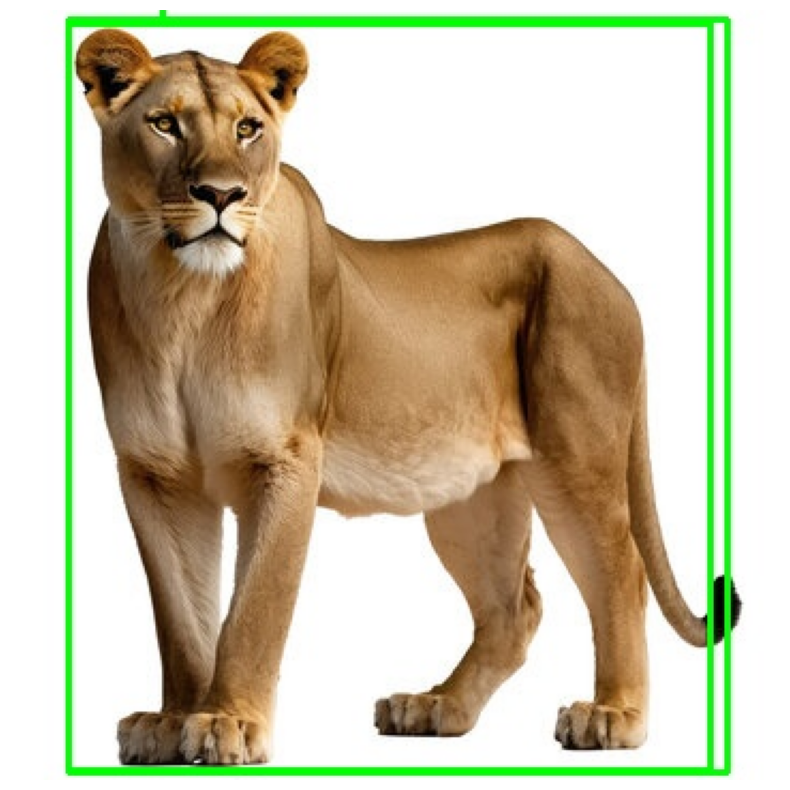

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:


import cv2
import numpy as np
import torch
from ultralytics import YOLO
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import Video, display

# Preprocessing: Background Subtraction and Image Normalization
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    fgbg = cv2.createBackgroundSubtractorMOG2()
    fgmask = fgbg.apply(gray)
    masked_img = cv2.bitwise_and(frame, frame, mask=fgmask)
    normalized_img = masked_img / 255.0
    return normalized_img, frame

# Object Detection with YOLOv8
def detect_animals(frame, model_path='yolov8n.pt'):
    model = YOLO(model_path)
    results = model(frame)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    return boxes

# CNN Classifier for Species Identification
def build_cnn_classifier(num_classes=4):  # Updated to 4 classes
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Movement Clustering with KMeans
def cluster_movement_patterns(features, n_clusters=3):
    if features.shape[0] < n_clusters:
        return np.zeros(features.shape[0], dtype=int)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)
    return labels

# Core Processing Function for a Single Frame
def process_frame(frame, cnn_model, prev_frame=None, species_names=None):
    processed_img, original_frame = preprocess_frame(frame)
    boxes = detect_animals(original_frame)
    motion_features = []
    if prev_frame is not None:  # Optical flow for videos
        prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
        curr_gray = cv2.cvtColor(original_frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            roi_flow = flow[y1:y2, x1:x2]
            mean_flow = np.mean(roi_flow, axis=(0, 1))
            motion_features.append(mean_flow)
    else:  # Fallback for images
        motion_features = np.zeros((max(1, len(boxes)), 2))
    cluster_labels = cluster_movement_patterns(motion_features) if len(motion_features) > 0 else np.zeros(len(boxes))
    species_predictions = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        roi = original_frame[y1:y2, x1:x2]
        if roi.size == 0:
            continue
        roi_resized = cv2.resize(roi, (224, 224))
        roi_normalized = roi_resized / 255.0
        pred = cnn_model.predict(np.expand_dims(roi_normalized, axis=0), verbose=0)
        species_id = np.argmax(pred, axis=1)[0]
        species_name = species_names[species_id] if species_names else str(species_id)
        species_predictions.append(species_name)
    return boxes, species_predictions, cluster_labels, original_frame

# Process a Single Image
def process_image(image_path, cnn_model, species_names=None):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    boxes, species, clusters, annotated_frame = process_frame(img, cnn_model, None, species_names)
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(annotated_frame, species[i], (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    output_path = "output_" + os.path.basename(image_path)
    cv2.imwrite(output_path, annotated_frame)
    return boxes, species, clusters, output_path

# Process a Video
def process_video(video_path, cnn_model, species_names=None, output_video_path="output_video.mp4"):
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video not found: {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Failed to open video: {video_path}")
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    results = []
    prev_frame = None
    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            boxes, species, clusters, annotated_frame = process_frame(frame, cnn_model, prev_frame, species_names)
            for i, box in enumerate(boxes):
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(annotated_frame, species[i], (x1, y1-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            out.write(annotated_frame)
            results.append((boxes, species, clusters))
            prev_frame = frame.copy()
    finally:
        cap.release()
        out.release()
        cv2.destroyAllWindows()
    return results, output_video_path

# Main function for Colab
def main():
    # Load trained CNN model from direct path
    model_path = "/content/cnn_model.h5"
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found at {model_path}. Please place cnn_model.h5 in /content/")
    cnn_model = tf.keras.models.load_model(model_path)

    # Species names (match dataset's class_indices)
    species_names = ["Cheeta", "Elephant", "Lion", "Zebra"]

    # Prompt user for input type
    print("Choose input type: 'image' or 'video'")
    input_type = input().strip().lower()
    while input_type not in ['image', 'video']:
        print("Invalid input. Please enter 'image' or 'video':")
        input_type = input().strip().lower()

    # Set direct file path based on input type
    if input_type == 'image':
        file_path = "/content/drive/MyDrive/Proj/lioness.jpg"
    else:
        file_path = "/content/drive/MyDrive/Proj/lioness.jpg"

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found at {file_path}. Please place {os.path.basename(file_path)} in /content/")

    # Process based on input type
    if input_type == 'image':
        try:
            boxes, species, clusters, output_path = process_image(file_path, cnn_model, species_names)
            print(f"Image processed. Detected {len(boxes)} animals")
            print(f"Species predictions: {species}")
            print(f"Movement clusters: {clusters}")
            print(f"Annotated image saved to: {output_path}")
            img = cv2.imread(output_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(10, 10))
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.show()
            files.download(output_path)
        except Exception as e:
            print(f"Error processing image: {e}")

    elif input_type == 'video':
        try:
            results, output_path = process_video(file_path, cnn_model, species_names)
            print(f"Video processed. Results for {len(results)} frames saved to: {output_path}")
            for i, (boxes, species, clusters) in enumerate(results):
                print(f"Frame {i+1}: Detected {len(boxes)} animals, Species: {species}, Clusters: {clusters}")
            display(Video(output_path, embed=True))
            files.download(output_path)
        except Exception as e:
            print(f"Error processing video: {e}")

if __name__ == "__main__":
    main()


Choose input type: 'image' or 'video'
image
Please upload your image file:


Saving WhatsApp Image 2025-05-17 at 1.39.27 PM.jpeg to WhatsApp Image 2025-05-17 at 1.39.27 PM.jpeg

0: 448x640 1 zebra, 204.8ms
Speed: 7.3ms preprocess, 204.8ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)
Image processed. Detected 1 animals
Species predictions: ['Elephant']
Movement clusters: [0]
Annotated image saved to: output_WhatsApp Image 2025-05-17 at 1.39.27 PM.jpeg


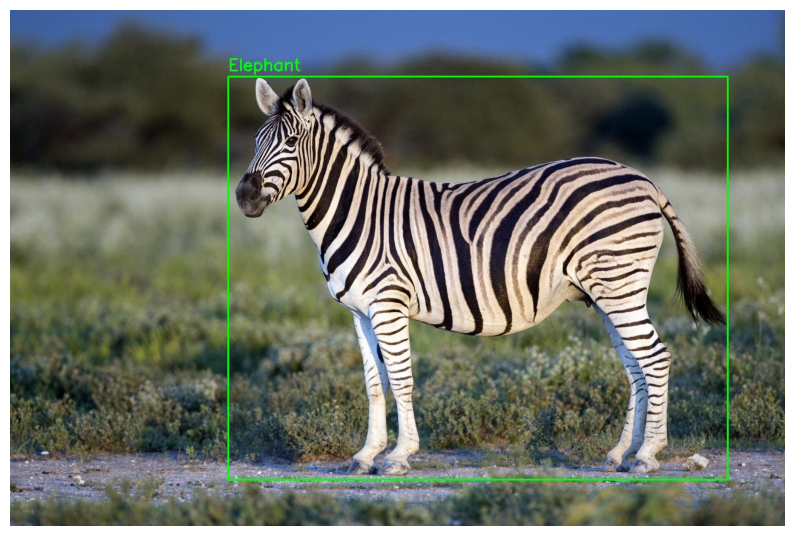

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
import cv2
import numpy as np
import torch
from ultralytics import YOLO
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import Video, display

# Preprocessing: Background Subtraction and Image Normalization
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    fgbg = cv2.createBackgroundSubtractorMOG2()
    fgmask = fgbg.apply(gray)
    masked_img = cv2.bitwise_and(frame, frame, mask=fgmask)
    normalized_img = masked_img / 255.0
    return normalized_img, frame

# Object Detection with YOLOv8
def detect_animals(frame, model_path='yolov8n.pt'):
    model = YOLO(model_path)
    results = model(frame)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    return boxes

# CNN Classifier for Species Identification
def build_cnn_classifier(num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Movement Clustering with KMeans
def cluster_movement_patterns(features, n_clusters=3):
    if features.shape[0] < n_clusters:
        return np.zeros(features.shape[0], dtype=int)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)
    return labels

# Core Processing Function for a Single Frame
def process_frame(frame, cnn_model, prev_frame=None, species_names=None):
    processed_img, original_frame = preprocess_frame(frame)
    boxes = detect_animals(original_frame)
    motion_features = []
    if prev_frame is not None:  # Optical flow for videos
        prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
        curr_gray = cv2.cvtColor(original_frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            roi_flow = flow[y1:y2, x1:x2]
            mean_flow = np.mean(roi_flow, axis=(0, 1))
            motion_features.append(mean_flow)
    else:  # Fallback for images
        motion_features = np.zeros((max(1, len(boxes)), 2))
    cluster_labels = cluster_movement_patterns(motion_features) if len(motion_features) > 0 else np.zeros(len(boxes))
    species_predictions = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        roi = original_frame[y1:y2, x1:x2]
        if roi.size == 0:
            continue
        roi_resized = cv2.resize(roi, (224, 224))
        roi_normalized = roi_resized / 255.0
        pred = cnn_model.predict(np.expand_dims(roi_normalized, axis=0), verbose=0)
        species_id = np.argmax(pred, axis=1)[0]
        species_name = species_names[species_id] if species_names else str(species_id)
        species_predictions.append(species_name)
    return boxes, species_predictions, cluster_labels, original_frame

# Process a Single Image
def process_image(image_path, cnn_model, species_names=None):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    boxes, species, clusters, annotated_frame = process_frame(img, cnn_model, None, species_names)
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(annotated_frame, species[i], (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    output_path = "output_" + os.path.basename(image_path)
    cv2.imwrite(output_path, annotated_frame)
    return boxes, species, clusters, output_path

# Process a Video
def process_video(video_path, cnn_model, species_names=None, output_video_path="output_video.mp4"):
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video not found: {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Failed to open video: {video_path}")
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    results = []
    prev_frame = None
    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            boxes, species, clusters, annotated_frame = process_frame(frame, cnn_model, prev_frame, species_names)
            for i, box in enumerate(boxes):
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(annotated_frame, species[i], (x1, y1-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            out.write(annotated_frame)
            results.append((boxes, species, clusters))
            prev_frame = frame.copy()
    finally:
        cap.release()
        out.release()
        cv2.destroyAllWindows()
    return results, output_video_path

# Main function for Colab
def main():
    # Load trained CNN model from direct path
    model_path = "/content/cnn_model.h5"
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found at {model_path}. Please place cnn_model.h5 in /content/")
    cnn_model = tf.keras.models.load_model(model_path)

    # Species names (match dataset's class_indices)
    species_names = ["Cheeta", "Elephant", "Lion", "Zebra"]

    # Prompt user for input type
    print("Choose input type: 'image' or 'video'")
    input_type = input().strip().lower()
    while input_type not in ['image', 'video']:
        print("Invalid input. Please enter 'image' or 'video':")
        input_type = input().strip().lower()

    # Prompt for file upload based on input type
    print(f"Please upload your {input_type} file:")
    uploaded = files.upload()
    if not uploaded:
        raise ValueError(f"No {input_type} file uploaded")

    # Get the uploaded file path
    file_path = list(uploaded.keys())[0]

    # Process based on input type
    if input_type == 'image':
        try:
            boxes, species, clusters, output_path = process_image(file_path, cnn_model, species_names)
            print(f"Image processed. Detected {len(boxes)} animals")
            print(f"Species predictions: {species}")
            print(f"Movement clusters: {clusters}")
            print(f"Annotated image saved to: {output_path}")
            img = cv2.imread(output_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(10, 10))
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.show()
            files.download(output_path)
        except Exception as e:
            print(f"Error processing image: {e}")

    elif input_type == 'video':
        try:
            results, output_path = process_video(file_path, cnn_model, species_names)
            print(f"Video processed. Results for {len(results)} frames saved to: {output_path}")
            for i, (boxes, species, clusters) in enumerate(results):
                print(f"Frame {i+1}: Detected {len(boxes)} animals, Species: {species}, Clusters: {clusters}")
            display(Video(output_path, embed=True))
            files.download(output_path)
        except Exception as e:
            print(f"Error processing video: {e}")

if __name__ == "__main__":
    main()


Choose input type: 'image' or 'video'
image
Please upload your image file:


Saving WhatsApp Image 2025-05-17 at 1.36.21 PM (2).jpeg to WhatsApp Image 2025-05-17 at 1.36.21 PM (2).jpeg

0: 576x640 1 elephant, 246.3ms
Speed: 5.9ms preprocess, 246.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)
Image processed. Detected 1 animals
Species predictions: ['Elephant']
Movement clusters: [0]
Annotated image saved to: output_WhatsApp Image 2025-05-17 at 1.36.21 PM (2).jpeg


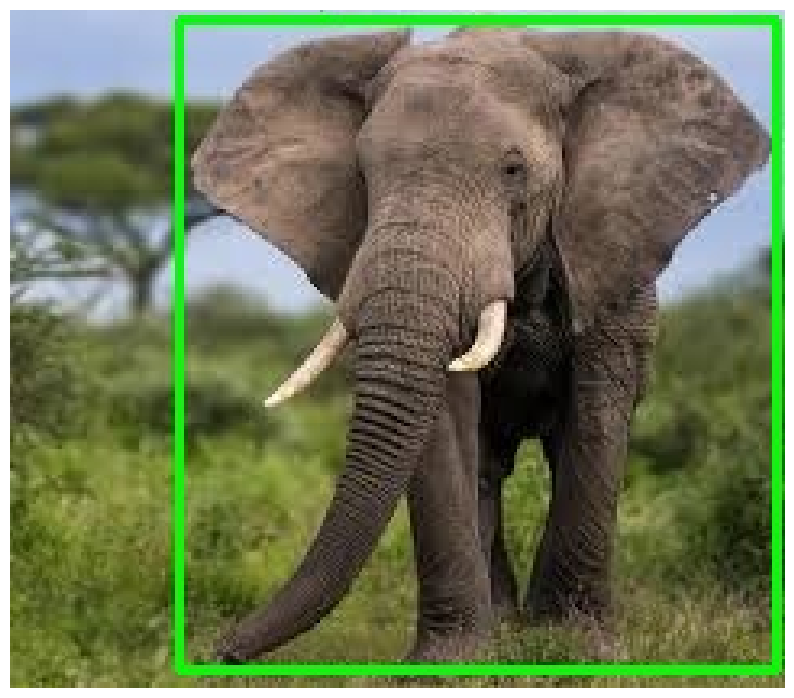

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
import cv2
import numpy as np
import torch
from ultralytics import YOLO
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import Video, display

# Preprocessing: Background Subtraction and Image Normalization
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    fgbg = cv2.createBackgroundSubtractorMOG2()
    fgmask = fgbg.apply(gray)
    masked_img = cv2.bitwise_and(frame, frame, mask=fgmask)
    normalized_img = masked_img / 255.0
    return normalized_img, frame

# Object Detection with YOLOv8
def detect_animals(frame, model_path='yolov8n.pt'):
    model = YOLO(model_path)
    results = model(frame)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    return boxes

# CNN Classifier for Species Identification
def build_cnn_classifier(num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Movement Clustering with KMeans
def cluster_movement_patterns(features, n_clusters=3):
    if features.shape[0] < n_clusters:
        return np.zeros(features.shape[0], dtype=int)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)
    return labels

# Core Processing Function for a Single Frame
def process_frame(frame, cnn_model, prev_frame=None, species_names=None):
    processed_img, original_frame = preprocess_frame(frame)
    boxes = detect_animals(original_frame)
    motion_features = []
    if prev_frame is not None:  # Optical flow for videos
        prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
        curr_gray = cv2.cvtColor(original_frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            roi_flow = flow[y1:y2, x1:x2]
            mean_flow = np.mean(roi_flow, axis=(0, 1))
            motion_features.append(mean_flow)
    else:  # Fallback for images
        motion_features = np.zeros((max(1, len(boxes)), 2))
    cluster_labels = cluster_movement_patterns(motion_features) if len(motion_features) > 0 else np.zeros(len(boxes))
    species_predictions = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        roi = original_frame[y1:y2, x1:x2]
        if roi.size == 0:
            continue
        roi_resized = cv2.resize(roi, (224, 224))
        roi_normalized = roi_resized / 255.0
        pred = cnn_model.predict(np.expand_dims(roi_normalized, axis=0), verbose=0)
        species_id = np.argmax(pred, axis=1)[0]
        species_name = species_names[species_id] if species_names else str(species_id)
        species_predictions.append(species_name)
    return boxes, species_predictions, cluster_labels, original_frame

# Process a Single Image
def process_image(image_path, cnn_model, species_names=None):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    boxes, species, clusters, annotated_frame = process_frame(img, cnn_model, None, species_names)
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(annotated_frame, species[i], (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    output_path = "output_" + os.path.basename(image_path)
    cv2.imwrite(output_path, annotated_frame)
    return boxes, species, clusters, output_path

# Process a Video
def process_video(video_path, cnn_model, species_names=None, output_video_path="output_video.mp4"):
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video not found: {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Failed to open video: {video_path}")
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    results = []
    prev_frame = None
    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            boxes, species, clusters, annotated_frame = process_frame(frame, cnn_model, prev_frame, species_names)
            for i, box in enumerate(boxes):
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(annotated_frame, species[i], (x1, y1-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            out.write(annotated_frame)
            results.append((boxes, species, clusters))
            prev_frame = frame.copy()
    finally:
        cap.release()
        out.release()
        cv2.destroyAllWindows()
    return results, output_video_path

# Main function for Colab
def main():
    # Load trained CNN model from direct path
    model_path = "/content/cnn_model.h5"
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found at {model_path}. Please place cnn_model.h5 in /content/")
    cnn_model = tf.keras.models.load_model(model_path)

    # Species names (match dataset's class_indices)
    species_names = ["Cheeta", "Elephant", "Lion", "Zebra"]

    # Prompt user for input type
    print("Choose input type: 'image' or 'video'")
    input_type = input().strip().lower()
    while input_type not in ['image', 'video']:
        print("Invalid input. Please enter 'image' or 'video':")
        input_type = input().strip().lower()

    # Prompt for file upload based on input type
    print(f"Please upload your {input_type} file:")
    uploaded = files.upload()
    if not uploaded:
        raise ValueError(f"No {input_type} file uploaded")

    # Get the uploaded file path
    file_path = list(uploaded.keys())[0]

    # Process based on input type
    if input_type == 'image':
        try:
            boxes, species, clusters, output_path = process_image(file_path, cnn_model, species_names)
            print(f"Image processed. Detected {len(boxes)} animals")
            print(f"Species predictions: {species}")
            print(f"Movement clusters: {clusters}")
            print(f"Annotated image saved to: {output_path}")
            img = cv2.imread(output_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(10, 10))
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.show()
            files.download(output_path)
        except Exception as e:
            print(f"Error processing image: {e}")

    elif input_type == 'video':
        try:
            results, output_path = process_video(file_path, cnn_model, species_names)
            print(f"Video processed. Results for {len(results)} frames saved to: {output_path}")
            for i, (boxes, species, clusters) in enumerate(results):
                print(f"Frame {i+1}: Detected {len(boxes)} animals, Species: {species}, Clusters: {clusters}")
            display(Video(output_path, embed=True))
            files.download(output_path)
        except Exception as e:
            print(f"Error processing video: {e}")

if __name__ == "__main__":
    main()


Choose input type: 'image' or 'video'
image
Please upload your image file:


Saving WhatsApp Image 2025-05-17 at 1.36.21 PM (1).jpeg to WhatsApp Image 2025-05-17 at 1.36.21 PM (1).jpeg

0: 416x640 1 bear, 174.1ms
Speed: 4.8ms preprocess, 174.1ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)
Image processed. Detected 1 animals
Species predictions: ['Elephant']
Movement clusters: [0]
Annotated image saved to: output_WhatsApp Image 2025-05-17 at 1.36.21 PM (1).jpeg


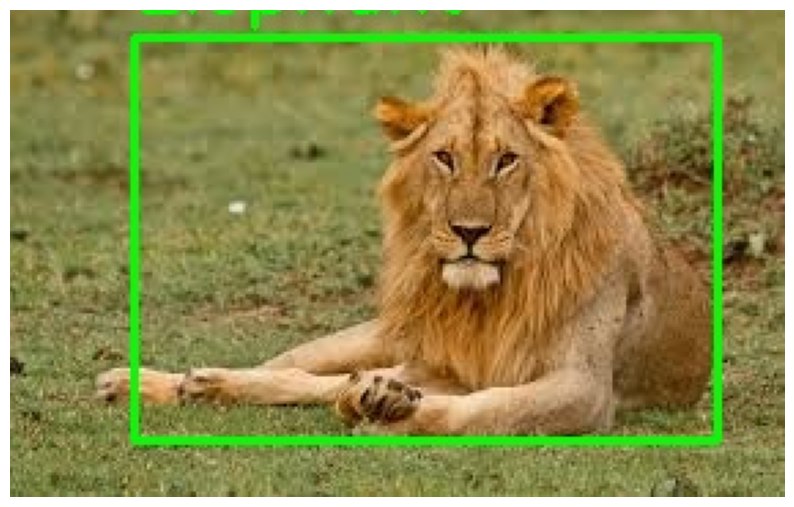

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
import cv2
import numpy as np
import torch
from ultralytics import YOLO
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import Video, display

# Preprocessing: Background Subtraction and Image Normalization
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    fgbg = cv2.createBackgroundSubtractorMOG2()
    fgmask = fgbg.apply(gray)
    masked_img = cv2.bitwise_and(frame, frame, mask=fgmask)
    normalized_img = masked_img / 255.0
    return normalized_img, frame

# Object Detection with YOLOv8
def detect_animals(frame, model_path='yolov8n.pt'):
    model = YOLO(model_path)
    results = model(frame)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    return boxes

# CNN Classifier for Species Identification
def build_cnn_classifier(num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Movement Clustering with KMeans
def cluster_movement_patterns(features, n_clusters=3):
    if features.shape[0] < n_clusters:
        return np.zeros(features.shape[0], dtype=int)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)
    return labels

# Core Processing Function for a Single Frame
def process_frame(frame, cnn_model, prev_frame=None, species_names=None):
    processed_img, original_frame = preprocess_frame(frame)
    boxes = detect_animals(original_frame)
    motion_features = []
    if prev_frame is not None:  # Optical flow for videos
        prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
        curr_gray = cv2.cvtColor(original_frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            roi_flow = flow[y1:y2, x1:x2]
            mean_flow = np.mean(roi_flow, axis=(0, 1))
            motion_features.append(mean_flow)
    else:  # Fallback for images
        motion_features = np.zeros((max(1, len(boxes)), 2))
    cluster_labels = cluster_movement_patterns(motion_features) if len(motion_features) > 0 else np.zeros(len(boxes))
    species_predictions = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        roi = original_frame[y1:y2, x1:x2]
        if roi.size == 0:
            continue
        roi_resized = cv2.resize(roi, (224, 224))
        roi_normalized = roi_resized / 255.0
        pred = cnn_model.predict(np.expand_dims(roi_normalized, axis=0), verbose=0)
        species_id = np.argmax(pred, axis=1)[0]
        species_name = species_names[species_id] if species_names else str(species_id)
        species_predictions.append(species_name)
    return boxes, species_predictions, cluster_labels, original_frame

# Process a Single Image
def process_image(image_path, cnn_model, species_names=None):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    boxes, species, clusters, annotated_frame = process_frame(img, cnn_model, None, species_names)
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(annotated_frame, species[i], (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    output_path = "output_" + os.path.basename(image_path)
    cv2.imwrite(output_path, annotated_frame)
    return boxes, species, clusters, output_path

# Process a Video
def process_video(video_path, cnn_model, species_names=None, output_video_path="output_video.mp4"):
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video not found: {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Failed to open video: {video_path}")
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    results = []
    prev_frame = None
    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            boxes, species, clusters, annotated_frame = process_frame(frame, cnn_model, prev_frame, species_names)
            for i, box in enumerate(boxes):
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(annotated_frame, species[i], (x1, y1-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            out.write(annotated_frame)
            results.append((boxes, species, clusters))
            prev_frame = frame.copy()
    finally:
        cap.release()
        out.release()
        cv2.destroyAllWindows()
    return results, output_video_path

# Main function for Colab
def main():
    # Load trained CNN model from direct path
    model_path = "/content/cnn_model.h5"
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found at {model_path}. Please place cnn_model.h5 in /content/")
    cnn_model = tf.keras.models.load_model(model_path)

    # Species names (match dataset's class_indices)
    species_names = ["Cheeta", "Elephant", "Lion", "Zebra"]

    # Prompt user for input type
    print("Choose input type: 'image' or 'video'")
    input_type = input().strip().lower()
    while input_type not in ['image', 'video']:
        print("Invalid input. Please enter 'image' or 'video':")
        input_type = input().strip().lower()

    # Prompt for file upload based on input type
    print(f"Please upload your {input_type} file:")
    uploaded = files.upload()
    if not uploaded:
        raise ValueError(f"No {input_type} file uploaded")

    # Get the uploaded file path
    file_path = list(uploaded.keys())[0]

    # Process based on input type
    if input_type == 'image':
        try:
            boxes, species, clusters, output_path = process_image(file_path, cnn_model, species_names)
            print(f"Image processed. Detected {len(boxes)} animals")
            print(f"Species predictions: {species}")
            print(f"Movement clusters: {clusters}")
            print(f"Annotated image saved to: {output_path}")
            img = cv2.imread(output_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(10, 10))
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.show()
            files.download(output_path)
        except Exception as e:
            print(f"Error processing image: {e}")

    elif input_type == 'video':
        try:
            results, output_path = process_video(file_path, cnn_model, species_names)
            print(f"Video processed. Results for {len(results)} frames saved to: {output_path}")
            for i, (boxes, species, clusters) in enumerate(results):
                print(f"Frame {i+1}: Detected {len(boxes)} animals, Species: {species}, Clusters: {clusters}")
            display(Video(output_path, embed=True))
            files.download(output_path)
        except Exception as e:
            print(f"Error processing video: {e}")

if __name__ == "__main__":
    main()
